# 03. Customer Segmentation (RFM)
---

## Introduction

After the general Exploratory Data Analysis (EDA), this notebook focuses on understanding customers at a deeper level. We will deploy two complementary segmentation techniques to build a complete picture of the customer base:

1. **RFM (Recency, Frequency, Monetary) Segmentation:** We will perform a classic, rule-based segmentation to group customers based on their purchasing behavior. This "top-down" approach allows us to create actionable, business-friendly segments like "Champions," "Need Attention," and "Hibernating/Lost."

2. **K-Means Clustering (Machine Learning):** To validate and refine our manual segments, we will also apply an unsupervised machine learning algorithm. This "bottom-up" approach will find the natural, mathematical clusters in the data based on R, F, and M. We will then compare these clusters to our manual segments to verify our findings and uncover deeper insights.

The goal is to build a robust, dual-validated customer segmentation model to guide the company's retention strategy.

In [26]:
# --- 2. Setup and Imports ---

# Importing standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk 

# Adding the project's root directory to the Python path
import sys
sys.path.append('..')

# Importing our custom functions
from src.data_utils import load_processed
from src.viz import plot_scatter, plot_bar, plot_heatmap,plot_count, plot_line, plot_box, plot_stacked_bar, plot_bubble, pie_plot, line_plot

# Configuring pandas and matplotlib for better display
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete.")

Setup complete.


In [27]:
# --- 3. Loading Analytics-Ready Data ---

# Load the final, enriched dataframe from the processed folder
df_analytics = load_processed('analytics_main_data')

# --- Verification ---
print("--- Analytics Data Verification ---")
print(f"DataFrame loaded successfully. Shape: {df_analytics.shape}")
display(df_analytics.head())

Loading processed data from: /home/lucas/olist-data-analysis-project/notebooks/../data/processed/analytics_main_data.parquet
--- Analytics Data Verification ---
DataFrame loaded successfully. Shape: (118310, 44)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_value,shipping_time_days,total_delivery_time,shipping_delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,perfumery,118.70,13,13,0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,None,None,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,auto,159.90,9,9,0


---
## 1. RFM Customer Segmentation

We will now segment customers based on their Recency, Frequency, and Monetary value. The first step is to calculate these three metrics for each unique customer.

### 1.1. Calculate Recency, Frequency, and Monetary Values

In [28]:
client_info = df_analytics.groupby('customer_unique_id')
last_purchased = client_info['order_purchase_timestamp'].max()
last_purchased

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2   2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f   2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064   2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078   2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255   2017-11-14 19:45:42
                                           ...        
fffcf5a5ff07b0908bd4e2dbc735a684   2017-06-08 21:00:36
fffea47cd6d3cc0a88bd621562a9d061   2017-12-10 20:07:56
ffff371b4d645b6ecea244b27531430a   2017-02-07 15:49:16
ffff5962728ec6157033ef9805bacc48   2018-05-02 15:17:41
ffffd2657e2aad2907e67c3e9daecbeb   2017-05-02 20:18:45
Name: order_purchase_timestamp, Length: 95420, dtype: datetime64[ns]

In [29]:
snapshot_date = df_analytics['order_purchase_timestamp'].max()+ pd.Timedelta(days=1)
recency_days = (snapshot_date - last_purchased).dt.days
recency_days

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    116
0000b849f77a49e4a4ce2b2a4ca5be3f    119
0000f46a3911fa3c0805444483337064    542
0000f6ccb0745a6a4b88665a16c9f078    326
0004aac84e0df4da2b147fca70cf8255    293
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    452
fffea47cd6d3cc0a88bd621562a9d061    267
ffff371b4d645b6ecea244b27531430a    573
ffff5962728ec6157033ef9805bacc48    124
ffffd2657e2aad2907e67c3e9daecbeb    489
Name: order_purchase_timestamp, Length: 95420, dtype: int64

In [30]:
purchase_freq = client_info['order_id'].nunique()
purchase_freq

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 95420, dtype: int64

In [31]:
money_spent = client_info['payment_value'].sum()
money_spent

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      27.19
0000f46a3911fa3c0805444483337064      86.22
0000f6ccb0745a6a4b88665a16c9f078      43.62
0004aac84e0df4da2b147fca70cf8255     196.89
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    4134.84
fffea47cd6d3cc0a88bd621562a9d061      84.58
ffff371b4d645b6ecea244b27531430a     112.46
ffff5962728ec6157033ef9805bacc48     133.69
ffffd2657e2aad2907e67c3e9daecbeb      71.56
Name: payment_value, Length: 95420, dtype: float64

In [32]:
rfm_df = pd.DataFrame(recency_days)
rfm_df.rename(columns={'order_purchase_timestamp': 'Recency'}, inplace=True)
rfm_df['Frequency'] = purchase_freq
rfm_df['Monetary'] = money_spent
rfm_df

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58
ffff371b4d645b6ecea244b27531430a,573,1,112.46


In [33]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,95420.000000,95420.000000,95420.000000
mean,243.600377,1.034018,213.968167
std,153.160320,0.211234,645.757464
min,1.000000,1.000000,0.000000
25%,119.000000,1.000000,63.990000
50%,224.000000,1.000000,113.330000
75%,353.000000,1.000000,203.300000
max,729.000000,16.000000,109312.640000


### 1.2. Creating RFM Scores

In order to analyze customer behavior, we will create scores for each RFM (Recency, Frequency, Monetary). As done above, each metric will be divided into 5 segments (1 to 5) using quintiles. Recency has been inverted so that a lower recency score is better (i.e., more recent purchases are better, and have value equal to 5). Frequency and Monetary scores will be assigned in a straightforward manner, where higher values receive higher scores.

In [34]:
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
eps = 0.1
freq_max = rfm_df['Frequency'].max() + eps
freq_bins = [0, 1.0, 2.0, freq_max]
freq_labels = [1, 2, 3]
rfm_df['F_score'] = pd.cut(rfm_df['Frequency'], bins=freq_bins, labels=freq_labels, right=True, include_lowest=True).astype(int)
m_labels = pd.qcut(rfm_df['Monetary'], q=5, duplicates='drop', labels=False)
rfm_df['M_score'] = (m_labels + 1).astype(int)
rfm_df['RFM_Score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)
display(rfm_df.sort_values(by='RFM_Score', ascending=False).head(10))

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
customer_unique_id,,,,,,,
34b0cd95480e55c2a701293a2b9671b3,6,3,531.49,5,3,5,535
3ea4185126195c34ed9949d8e406d570,47,3,806.63,5,3,5,535
6a6a7141119ceaeca4dfbae7a580a515,46,3,330.00,5,3,5,535
c7c19110042036e6266adc998cbf1289,30,3,733.01,5,3,5,535
4e65032f1f574189fb793bac5a867bbc,81,5,530.97,5,3,5,535
c8460e4251689ba205045f3ea17884a1,26,4,27935.46,5,3,5,535
d75acd4c5b7b4dfd32b9d9172b195419,91,3,615.55,5,3,5,535
9689908caf4de73724feed92175d867a,31,3,556.29,5,3,5,535
96f9204de777192f8feb7776d3cd09b4,25,3,315.77,5,3,5,535


### 1.3. Creating Customer Segments

With the RFM scores calculated, we can now group customers into meaningful segments. This allows for a high-level understanding of the customer base and enables targeted marketing actions. We will create segments based on the Recency and Frequency scores. The categories will be:
- **Champions:** Customers who are highly engaged (frequently buy) and have made recent purchases. **(R >= 4, F >= 4)**
- **Potential Loyalists:** Customers who have purchased multiple times but may not have bought recently. **(R >= 4, F >= 2)**
- **Need Attention:** Customers who have not purchased in a while but have a history of buying. **(R >= 3, F <= 3)**
- **At Risk:** Customers who have purchased frequently in the past but have not bought anything recently. **(R <= 2, F >= 3)**
- **Hibernating/Lost:** Customers who have not purchased in a long time and have low purchase frequency. **(R <= 2, F <= 2)**
- **Others:** Customers who do not fit into the above categories.

In [35]:
def segment(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    
    if r >= 4 and f == 3:                
        return 'Champions'
    elif r >= 4 and f >= 2:             
        return 'Potential Loyalists'
    elif r >= 3 and f <= 2:
        return 'Need Attention'
    elif r <= 2 and f == 3:
        return 'At Risk'
    elif r <= 2 and f == 1:
        return 'Hibernating/Lost'
    else:
        return 'Others'

    

In [36]:
rfm_df['Segment'] = rfm_df.apply(segment, axis=1)
rfm_df

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,4,414,Need Attention
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1,411,Need Attention
0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2,112,Hibernating/Lost
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1,211,Hibernating/Lost
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4,214,Hibernating/Lost
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,4134.84,1,1,5,115,Hibernating/Lost
fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58,3,1,2,312,Need Attention
ffff371b4d645b6ecea244b27531430a,573,1,112.46,1,1,3,113,Hibernating/Lost


In [37]:
# --- Diagnosis---
print(rfm_df.groupby('F_score')['Frequency'].agg(['min','max','count']))
print(pd.crosstab(rfm_df['Frequency'], rfm_df['Segment']).head(10))
display("--- FREQUENCY DISTRIBUTION BY SEGMENT ---")
print(rfm_df.groupby('Segment')['Frequency'].describe())

         min  max  count
F_score                 
1          1    1  92507
2          2    2   2673
3          3   16    240
Segment    At Risk  Champions  Hibernating/Lost  Need Attention  Others  \
Frequency                                                                 
1                0          0             37083           55424       0   
2                0          0                 0             588     960   
3               64         97                 0               0      31   
4                7         20                 0               0       2   
5                0          8                 0               0       1   
6                1          3                 0               0       1   
7                0          2                 0               0       1   
9                0          0                 0               0       1   
16               0          1                 0               0       0   

Segment    Potential Loyalists  
Frequency       

'--- FREQUENCY DISTRIBUTION BY SEGMENT ---'

                       count      mean       std  min  25%  50%  75%   max
Segment                                                                   
At Risk                 72.0  3.138889  0.453641  3.0  3.0  3.0  3.0   6.0
Champions              131.0  3.503817  1.377702  3.0  3.0  3.0  4.0  16.0
Hibernating/Lost     37083.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
Need Attention       56012.0  1.010498  0.101920  1.0  1.0  1.0  1.0   2.0
Others                 997.0  2.054162  0.368263  2.0  2.0  2.0  2.0   9.0
Potential Loyalists   1125.0  2.000000  0.000000  2.0  2.0  2.0  2.0   2.0


### 1.4. Analyzing the RFM Segments

Now that we have segmented our customers, let's analyze the characteristics of each segment to understand our customer base better. We will look at the size of each segment and their average Recency, Frequency, and Monetary values.

In [38]:
rfm_data = rfm_df.groupby('Segment')
rfm_data_plot = rfm_data.size()
rfm_data_plot.sort_values(ascending=False)

Segment
Need Attention         56012
Hibernating/Lost       37083
Potential Loyalists     1125
Others                   997
Champions                131
At Risk                   72
dtype: int64

/home/lucas/olist-data-analysis-project/notebooks/../src/viz.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=colors, hue=hue, orient=orientation)


Plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/customer_segments_distribution.png


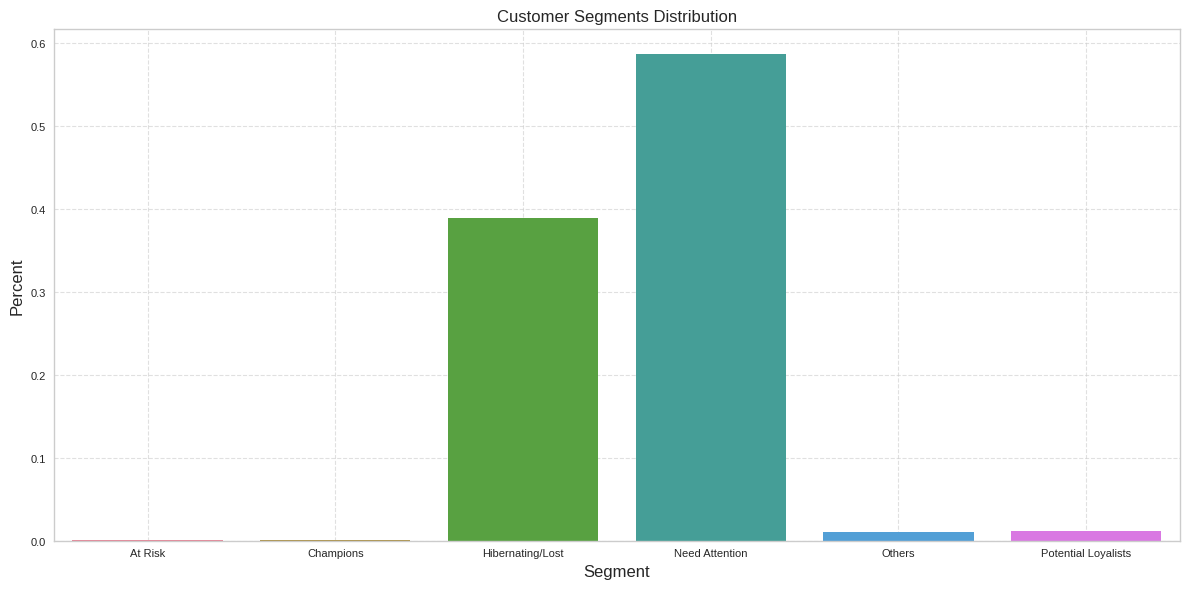

In [39]:
plot_bar(x=rfm_data_plot.index,y=rfm_data_plot.values/rfm_data_plot.sum(), title='Customer Segments Distribution', xlabel='Segment', ylabel='Percent', save_path='customer_segments_distribution.png')

In [40]:
rfm_plot2 = rfm_data[['Recency', 'Frequency', 'Monetary']].mean()
rfm_plot2

,Recency,Frequency,Monetary
Segment,,,
At Risk,400.083333,3.138889,748.297083
Champions,94.129771,3.503817,1048.502595
Hibernating/Lost,401.308093,1.000000,209.349855
Need Attention,139.880740,1.010498,205.153442
Others,381.668004,2.054162,463.881775
Potential Loyalists,94.204444,2.000000,452.218604


/home/lucas/olist-data-analysis-project/notebooks/../src/viz.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=colors, hue=hue, orient=orientation)


Plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/average_recency_by_segment.png


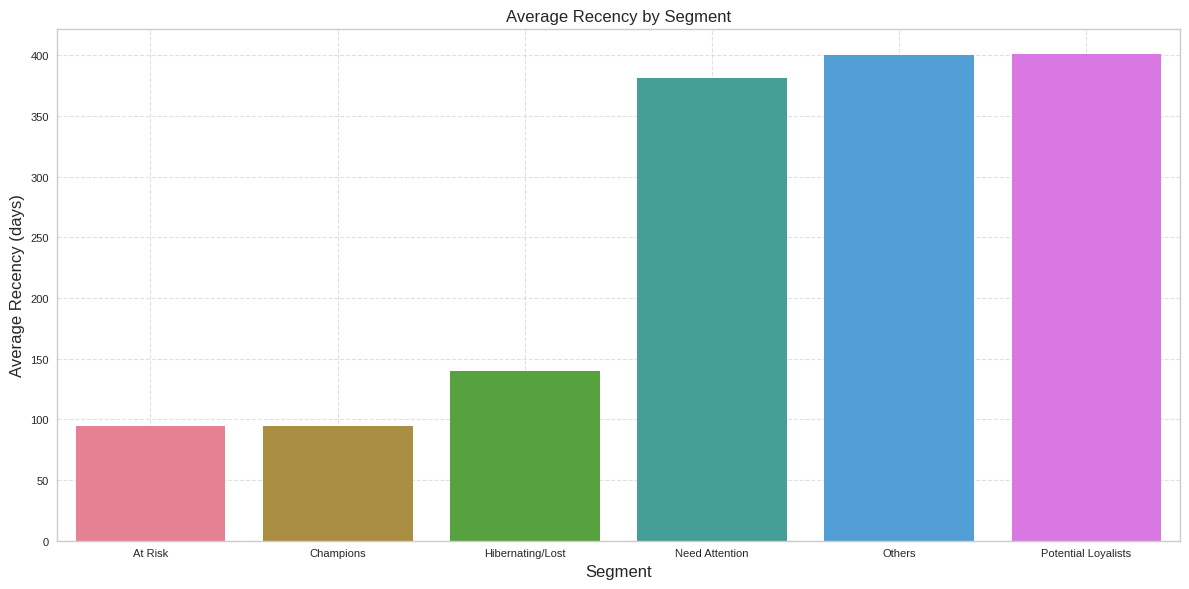

/home/lucas/olist-data-analysis-project/notebooks/../src/viz.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=colors, hue=hue, orient=orientation)


Plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/average_frequency_by_segment.png


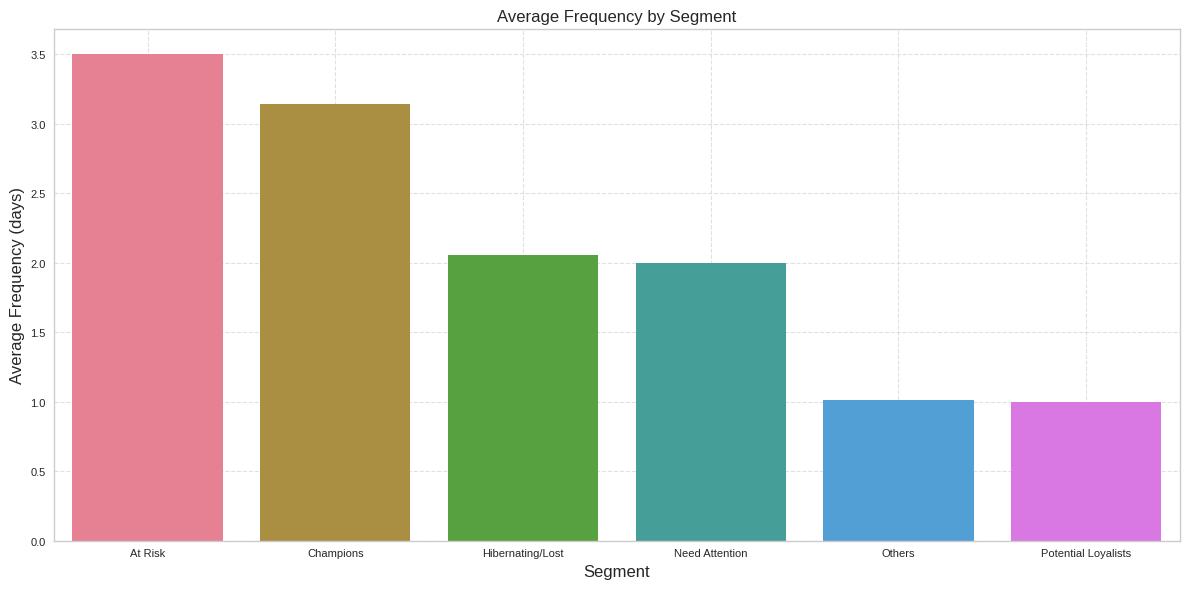

/home/lucas/olist-data-analysis-project/notebooks/../src/viz.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=colors, hue=hue, orient=orientation)


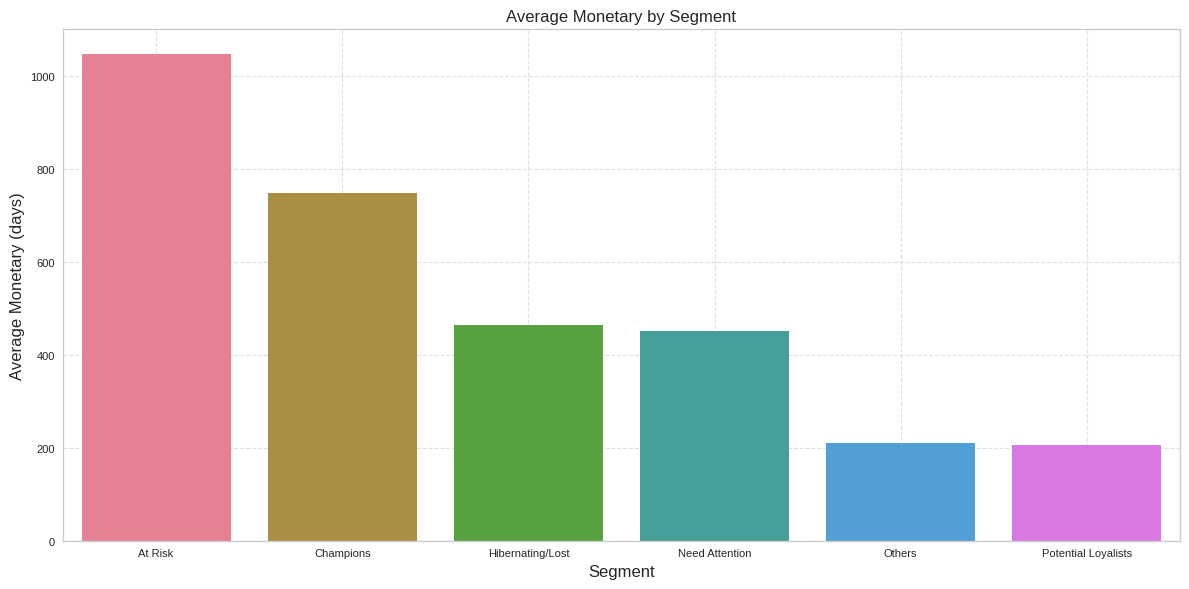

In [41]:
plot_bar(rfm_plot2.index, rfm_plot2['Recency'].sort_values(ascending=True), title='Average Recency by Segment', xlabel='Segment', ylabel='Average Recency (days)', save_path='average_recency_by_segment.png')
plot_bar(rfm_plot2.index, rfm_plot2['Frequency'].sort_values(ascending=False), title='Average Frequency by Segment', xlabel='Segment', ylabel='Average Frequency (days)', save_path='average_frequency_by_segment.png')
plot_bar(rfm_plot2.index, rfm_plot2['Monetary'].sort_values(ascending=False), title='Average Monetary by Segment', xlabel='Segment', ylabel='Average Monetary (days)')

In [42]:
# The mean monetary value can be distorted by outliers. So let's analyze the whole data in order to compare if the distribution is skewed.

rfm_data.describe()

Recency                                               \
                       count        mean        std    min     25%    50%   
Segment                                                                     
At Risk                 72.0  400.083333  93.569850  279.0  331.75  373.5   
Champions              131.0   94.129771  52.975814    6.0   43.00   95.0   
Hibernating/Lost     37083.0  401.308093  94.148713  274.0  319.00  389.0   
Need Attention       56012.0  139.880740  76.037434    5.0   74.00  141.0   
Others                 997.0  381.668004  91.032603  184.0  306.00  368.0   
Potential Loyalists   1125.0   94.204444  50.688630    1.0   47.00   94.0   

                                  Frequency                                \
                       75%    max     count      mean       std  min  25%   
Segment                                                                     
At Risk              456.0  606.0      72.0  3.138889  0.453641  3.0  3.0   
Champions            141.0  182.0     131.0  3.503817  1.377702  3.0  3.0   
Hibernating/Lost     473.0  729.0   37083.0  1.000000  0.000000  1.0  1.0   
Need Attention       204.0  273.0   56012.0  1.010498  0.101920  1.0  1.0   
Others               448.0  697.0     997.0  2.054162  0.368263  2.0  2.0   
Potential Loyalists  137.0  182.0    1125.0  2.000000  0.000000  2.0  2.0   

                                    Monetary                                   \
                     50%  75%   max    count         mean          std    min   
Segment                                                                         
At Risk              3.0  3.0   6.0     72.0   748.297083  1193.366782  46.86   
Champions            3.0  4.0  16.0    131.0  1048.502595  2539.142153  88.27   
Hibernating/Lost     1.0  1.0   1.0  37083.0   209.349855   778.248477   0.00   
Need Attention       1.0  1.0   2.0  56012.0   205.153442   497.427124   9.59   
Others               2.0  2.0   9.0    997.0   463.881775  1034.016973  38.24   
Potential Loyalists  2.0  2.0   2.0   1125.0   452.218604  1043.646150  34.97   

                                                              R_score  \
                          25%      50%        75%        max    count   
Segment                                                                 
At Risk              250.9875  438.550   877.7475    9601.92     72.0   
Champions            325.3050  494.510  1056.6050   27935.46    131.0   
Hibernating/Lost      62.6300  107.830   196.8100  109312.64  37083.0   
Need Attention        63.2700  112.595   197.5800   44048.00  56012.0   
Others               154.4900  251.650   446.2800   19342.26    997.0   
Potential Loyalists  152.6900  250.960   437.0800   25051.89   1125.0   

                                                                  F_score  \
                         mean       std  min  25%  50%  75%  max    count   
Segment                                                                     
At Risk              1.569444  0.498629  1.0  1.0  2.0  2.0  2.0     72.0   
Champions            4.519084  0.501554  4.0  4.0  5.0  5.0  5.0    131.0   
Hibernating/Lost     1.500822  0.500006  1.0  1.0  2.0  2.0  2.0  37083.0   
Need Attention       3.990556  0.819654  3.0  3.0  4.0  5.0  5.0  56012.0   
Others               1.615848  0.557776  1.0  1.0  2.0  2.0  3.0    997.0   
Potential Loyalists  4.520000  0.499822  4.0  4.0  5.0  5.0  5.0   1125.0   

                                                                  M_score  \
                         mean       std  min  25%  50%  75%  max    count   
Segment                                                                     
At Risk              3.000000  0.000000  3.0  3.0  3.0  3.0  3.0     72.0   
Champions            3.000000  0.000000  3.0  3.0  3.0  3.0  3.0    131.0   
Hibernating/Lost     1.000000  0.000000  1.0  1.0  1.0  1.0  1.0  37083.0   
Need Attention       1.010498  0.101920  1.0  1.0  1.0  1.0  2.0  56012.0   
Others      

In [43]:
# As we can see, the monetary value is the only one that is highly skewed. Let's use the median to represent it better.
rfm_plot2['Monetary'] = rfm_data['Monetary'].median()
rfm_plot2

,Recency,Frequency,Monetary
Segment,,,
At Risk,400.083333,3.138889,438.550
Champions,94.129771,3.503817,494.510
Hibernating/Lost,401.308093,1.000000,107.830
Need Attention,139.880740,1.010498,112.595
Others,381.668004,2.054162,251.650
Potential Loyalists,94.204444,2.000000,250.960


/home/lucas/olist-data-analysis-project/notebooks/../src/viz.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=colors, hue=hue, orient=orientation)


Plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/median_monetary_by_segment.png


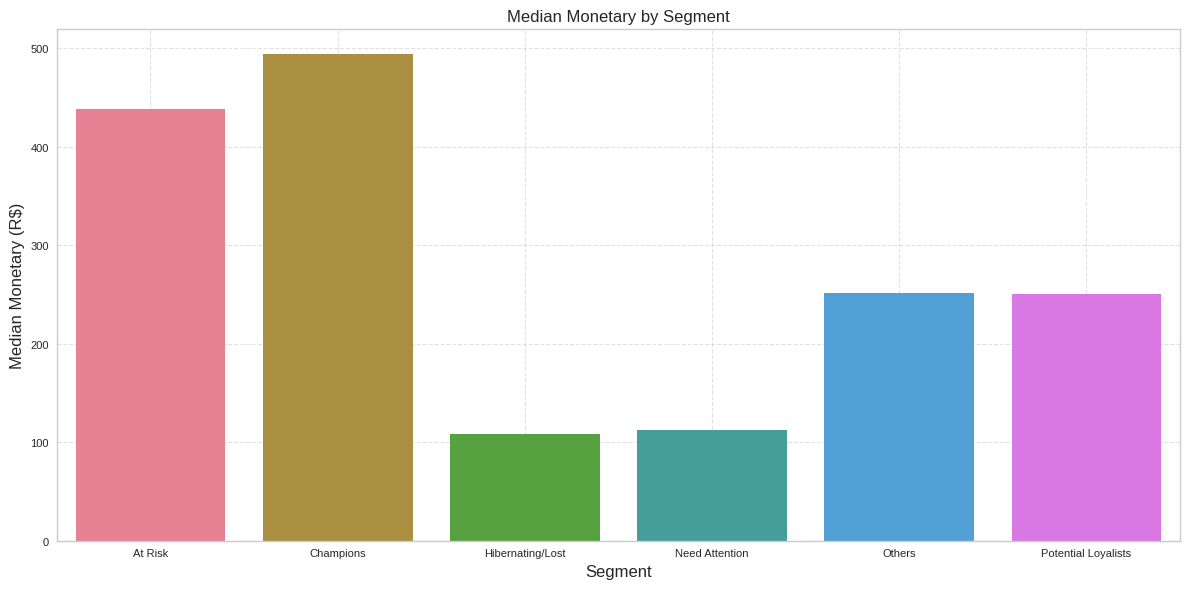

In [44]:
plot_bar(rfm_plot2.index, rfm_plot2['Monetary'], title='Median Monetary by Segment', xlabel='Segment', ylabel='Median Monetary (R$)', save_path='median_monetary_by_segment.png')

### Insight: A Chasm Between Single-Purchase Customers and a Rare, High-Value Loyal Elite

The RFM analysis reveals a stark reality: the customer base is almost entirely composed of single-purchase clients. The business challenge is not just retention, but **fostering the second purchase**, a behavior that is currently an extreme rarity.

* **Dominance of Single Purchases:** The Hibernating/Lost (37,083 customers) and Need Attention (56,012 customers) segments are almost exclusively single-purchase clients. Together, they account for **97.5% of the entire customer base**. This confirms that the business model is almost completely **dependent** on new customer acquisition.

* **Need Attention is the Main "Battleground":** The largest segment by far is Need Attention (56,012 customers). These are recent single-purchase clients. This group represents the single greatest opportunity and risk: they are the main pipeline that will either churn into the massive Hibernating/Lost segment or, with intervention, be converted into a multi-purchase segment.

* **Loyalty is a Rare but Extremely Valuable Anomaly**: The multi-purchase segments (Champions, Potential Loyalists, At Risk, Others) represent only 2.5% of all customers. However, these segments are disproportionately valuable. The Champions segment (131 customers) has a mean monetary value ($\approx$ R$1048), **over 5 times higher** than the single-purchase segments (R205-R$209).

**Business Implication:** The core business strategy must pivot aggressively towards **customer retention and re-engagement**: 

-  **1. For the 97.5% (Mass Market):** The largest opportunity lies in creating targeted campaigns for the Need Attention segment. The only goal should be converting them into Potential Loyalists by securing a second order.

-  **2. For the 2.5% (Loyal Elite):** High-value retention campaigns (VIP programs, special access) must be directed at the tiny but critical multi-purchase segments (Champions, Potential Loyalists, At Risk). Protecting this small group is essential, as they represent the only source of proven loyalty the business has.

---
## 2. Automated Segmentation with KMeans Clustering

In our first part of this analysis, we created customer segments using business rules based on quartiles (e.g., 'Champions', 'At Risk', 'Lost'). This approach is excellent for direct business interpretation and generating the insights we saw. Now, we will apply an **unsupervised learning**, the KMeans, to see if the data itself suggests "natural" groupings of customers, free from any bias or predefined rules.

### 2.1 Data Preparation: Standardization 

Before applying KMeans, there is a crucial technical prerequisite: the algorithm is very sensitive to the **scale** of the data.

As we saw, our 'monetary_value' (e.g., R$ 500.00) values are, on average, much larger than those of 'frequency' (e.g., 1 or 2). If we use the raw data, KMeans would give disproportionate weight to money and almost entirely ignore recency and frequency. To correct this, our first step will be to **standardize** the three variables (R, F, and M) so that they all have the same scale of importance (mean 0 and standard deviation 1) using Scikit-learn's StandardScaler.

In [45]:
from sklearn.preprocessing import StandardScaler

rfm_kmeans = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()

scaler = StandardScaler()
rfm_kmeans[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_kmeans[['Recency', 'Frequency', 'Monetary']])

kmeans_scaled = pd.DataFrame(rfm_kmeans, columns=['Recency', 'Frequency', 'Monetary'])


# Quick Check
print("Original Data Shape:", rfm_df[['Recency', 'Frequency', 'Monetary']].shape)
print("Standardized Data Shape:", kmeans_scaled.shape)
print("\n--- Original Sample ---")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].head())
print("\n--- Standardized Sample ---")
print(kmeans_scaled.head())

Original Data Shape: (95420, 3)
Standardized Data Shape: (95420, 3)

--- Original Sample ---
                                  Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19
0000f46a3911fa3c0805444483337064      542          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62
0004aac84e0df4da2b147fca70cf8255      293          1    196.89

--- Standardized Sample ---
                                   Recency  Frequency  Monetary
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2 -0.833121  -0.161045 -0.111603
0000b849f77a49e4a4ce2b2a4ca5be3f -0.813533  -0.161045 -0.289240
0000f46a3911fa3c0805444483337064  1.948293  -0.161045 -0.197828
0000f6ccb0745a6a4b88665a16c9f078  0.537999  -0.161045 -0.263797
0004aac84e0df4da2b147fca70cf8255  0.322537  -0.161045

### 2.2 Finding the Ideal K: The Elbow Method

With the data standardized, the next question is: "How many clusters (K) should we create?". To answer this objectively, we use the **Elbow Method**.

Plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/elbow_method_kmeans.png


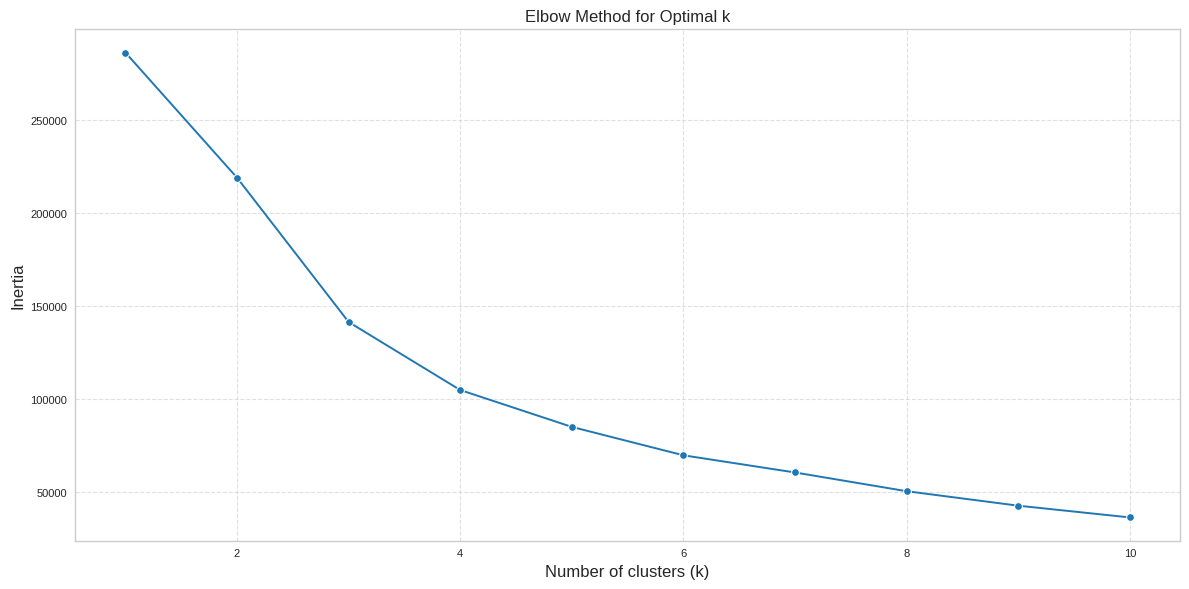

In [46]:
from sklearn.cluster import KMeans

# Elbow Method to find the optimal number of clusters

k_values = []
inertia_values = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kmeans_scaled)
    k_values.append(k)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Curve
line_plot(x=k_values, y=inertia_values, title='Elbow Method for Optimal k', xlabel='Number of clusters (k)', ylabel='Inertia', save_path='elbow_method_kmeans.png')

**Analysis Result:** The plot we generated clearly showed that the Inertia had a massive drop from K=2 to K=3 (from ~219k to ~141k), and then the curve flattened out. This indicates that **K=3** is the ideal choice, balancing simplicity (few groups) with efficiency (well-defined groups).

### 2.3 Final Training Model and Cluster Analysis

With K=3 defined, we trained the final KMeans model using our standardized data. We then extracted the cluster labels (0, 1, or 2) for each customer and added them back to our original dataframe (rfm_kmeans_final) for analysis.

In [47]:
kmeans_final = KMeans(n_clusters=3, random_state=42).fit(kmeans_scaled)
cluster_info = kmeans_final.labels_
rfm_kmeans_final = rfm_df.copy()
rfm_kmeans_final['Cluster'] = cluster_info
kmeans_scaled['Cluster'] = cluster_info

# --- 3. Checking results ---

print("--- Standardized DataFrame with Clusters ---")
print(kmeans_scaled.head())

print("\n--- Original DataFrame with Clusters ---")
print(rfm_kmeans_final.head())

print("\n--- Clients Counts per Cluster ---")
print(rfm_kmeans_final['Cluster'].value_counts())

# # Display the mean values of each feature for each cluster
# print("--- CLUSTER CENTROIDS ---")
# display(rfm_kmeans_final.groupby('Cluster').mean())

# # Visualize the clusters using a pairplot
# plt.figure(figsize=(10, 8))
# sns.pairplot(rfm_kmeans_final, hue='Cluster', diag_kind='auto', palette='Set2')
# plt.suptitle('K-Means Clusters (k=4)', y=1.02)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

# display(rfm_kmeans_final['Cluster'].value_counts().sort_index())

# display(rfm_kmeans_final.groupby('Cluster').quantile([0.25, 0.5, 0.75]))


--- Standardized DataFrame with Clusters ---
                                   Recency  Frequency  Monetary  Cluster
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2 -0.833121  -0.161045 -0.111603        1
0000b849f77a49e4a4ce2b2a4ca5be3f -0.813533  -0.161045 -0.289240        1
0000f46a3911fa3c0805444483337064  1.948293  -0.161045 -0.197828        0
0000f6ccb0745a6a4b88665a16c9f078  0.537999  -0.161045 -0.263797        0
0004aac84e0df4da2b147fca70cf8255  0.322537  -0.161045 -0.026447        0

--- Original DataFrame with Clusters ---
                                  Recency  Frequency  Monetary  R_score  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90        4   
0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19        4   
0000f46a3911fa3c0805444483337064      542          1     86.22        1   
0000f6ccb0745a6a4b88665a16c

In [48]:
cluster_analysis_mean = rfm_kmeans_final.groupby('Cluster').agg(
    Recency_avg=('Recency', 'mean'),
    Frequency_avg=('Frequency', 'mean'),
    Monetary_avg=('Monetary', 'mean'),
    Count=('Cluster', 'size')
).sort_values(by='Recency_avg', ascending=False) 

cluster_analysis_median = rfm_kmeans_final.groupby('Cluster').agg(
    Recency_avg=('Recency', 'median'),
    Frequency_avg=('Frequency', 'median'),
    Monetary_avg=('Monetary', 'median'),
    Count=('Cluster', 'size')
).sort_values(by='Recency_avg', ascending=False) 
print("--- Average Profile of Each Cluster (KMeans) ---")
print(cluster_analysis_mean)
print(cluster_analysis_median)

--- Average Profile of Each Cluster (KMeans) ---
         Recency_avg  Frequency_avg  Monetary_avg  Count
Cluster                                                 
0         393.609907       1.000000    201.144477  39365
2         226.196179       2.107472    653.954971   2931
1         133.403226       1.000000    199.195245  53124
         Recency_avg  Frequency_avg  Monetary_avg  Count
Cluster                                                 
0              381.0            1.0        108.19  39365
2              205.0            2.0        263.90   2931
1              135.0            1.0        111.60  53124


Box plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/boxplot_recency_by_cluster.png


<Figure size 1800x600 with 0 Axes>

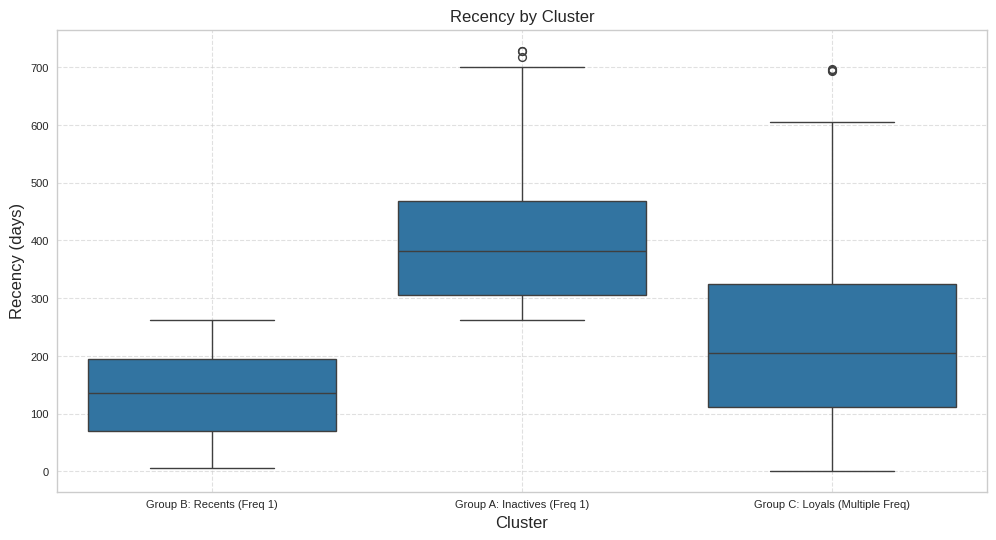

Box plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/boxplot_frequency_by_cluster.png


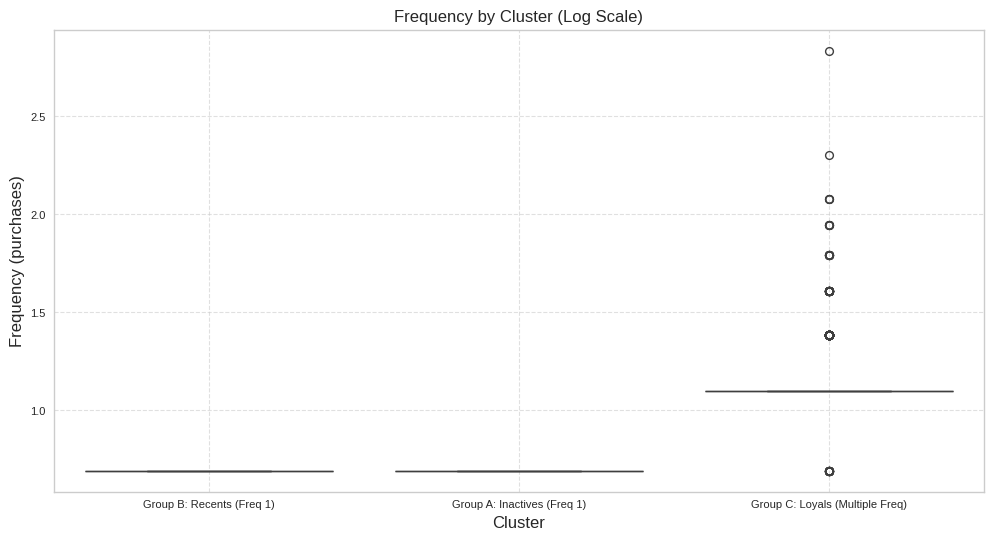

Box plot saved at: /home/lucas/olist-data-analysis-project/notebooks/../outputs/figures/boxplot_monetary_by_cluster.png


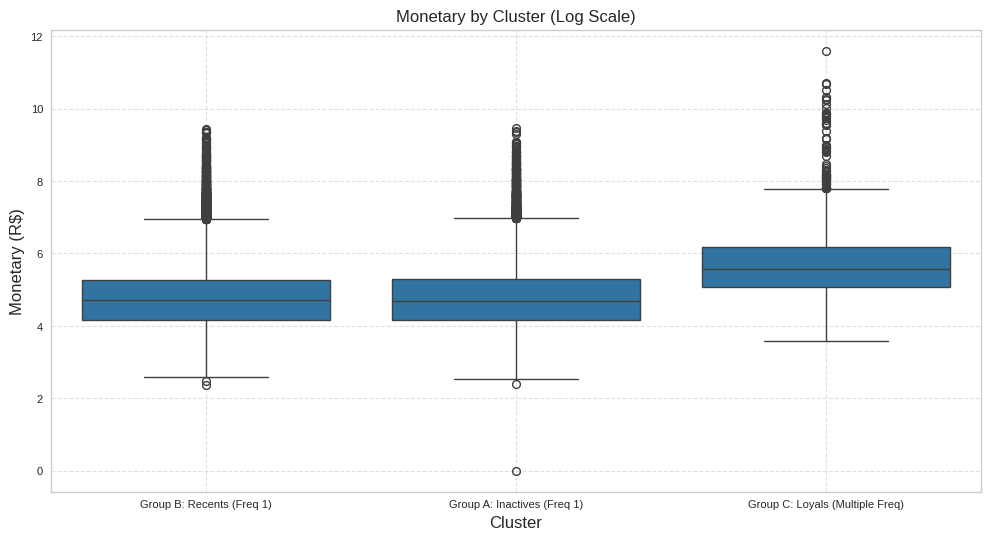

In [49]:
# Definindo os nomes dos clusters para os gráficos
rfm_kmeans_final['Cluster_Name'] = rfm_kmeans_final['Cluster'].map({
    0: 'Group A: Inactives (Freq 1)',
    1: 'Group B: Recents (Freq 1)',
    2: 'Group C: Loyals (Multiple Freq)',
})


# Taking log transform to better visualization, since we will probably have many outliers

rfm_kmeans_final['Frequency_log'] = np.log1p(rfm_kmeans_final['Frequency'])
rfm_kmeans_final['Monetary_log'] = np.log1p(rfm_kmeans_final['Monetary'])

# Boxplot 
plt.figure(figsize=(18, 6))
plot_box(df=rfm_kmeans_final, x='Cluster_Name', y='Recency', title='Recency by Cluster', xlabel='Cluster', ylabel='Recency (days)', save_path='boxplot_recency_by_cluster.png')
plot_box(df=rfm_kmeans_final, x='Cluster_Name', y='Frequency_log', title='Frequency by Cluster (Log Scale)', xlabel='Cluster', ylabel='Frequency (purchases)', save_path='boxplot_frequency_by_cluster.png')
plot_box(df=rfm_kmeans_final, x='Cluster_Name', y='Monetary_log', title='Monetary by Cluster (Log Scale)', xlabel='Cluster', ylabel='Monetary (R$)', save_path='boxplot_monetary_by_cluster.png')
plt.show()



--- Comparisson: Manual Segments Manuais vs. KMeans Segments ---
Cluster_Name         Group A: Inactives (Freq 1)  Group B: Recents (Freq 1)  \
Segment                                                                       
At Risk                                        0                          0   
Champions                                      0                          0   
Hibernating/Lost                           37075                          0   
Need Attention                              2290                      53124   
Others                                         0                          0   
Potential Loyalists                            0                          0   

Cluster_Name         Group C: Loyals (Multiple Freq)  
Segment                                               
At Risk                                           72  
Champions                                        131  
Hibernating/Lost                                   8  
Need Attention             

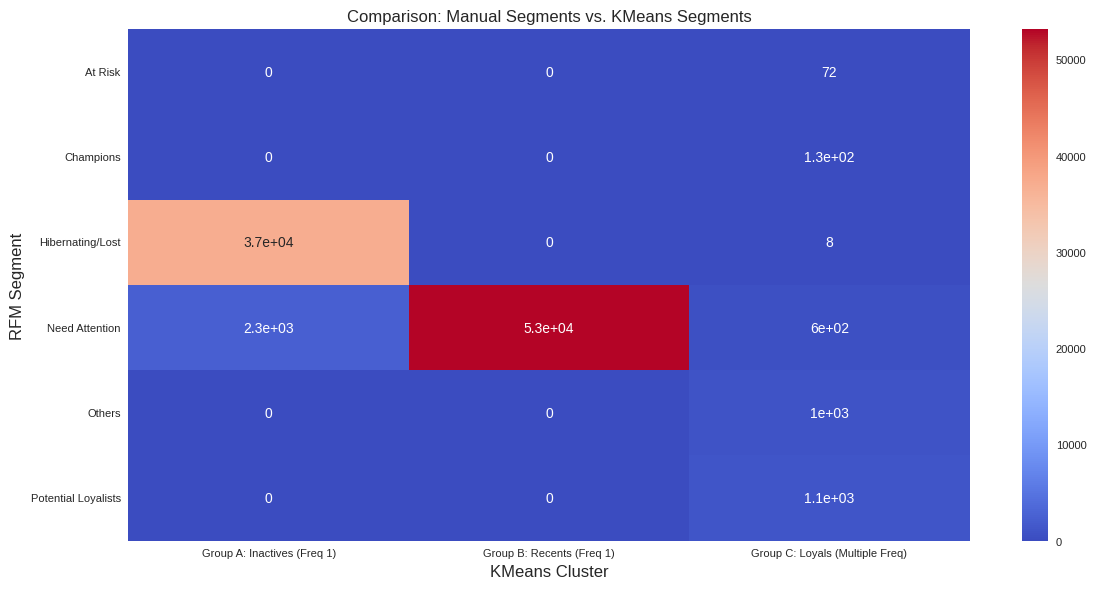

In [50]:
# Let's compare KMeans cluster analysis with our RFM segmentation

comparison_table = pd.crosstab(index=rfm_kmeans_final['Segment'], 
                             columns=rfm_kmeans_final['Cluster_Name'])

print("--- Comparisson: Manual Segments Manuais vs. KMeans Segments ---")
print(comparison_table)


# Visualize the comparison with a heatmap

plot_heatmap(comparison_table, title='Comparison: Manual Segments vs. KMeans Segments', xlabel='KMeans Cluster', ylabel='RFM Segment', save_path='heatmap_comparison_segments.png')

### Insight: K-Means Confirms Manual Segmentation and Validates Strategy

The comparison between the manual segmentation (Part 1) and the K-Means clustering (Part 2) indicates clear methodological convergence. The prior apparent contradiction is resolved: both approaches provide corroborating evidence for the same underlying segmentation structure.

**Methodological convergence:** A top-down rule-based segmentation and a bottom-up distance-based clustering procedure produced consistent outcomes, reinforcing the validity of the segmentation labels and their operational interpretations.

**Validation of the Loyal Elite:** The K-Means model identifies **Group C: Loyal (Multi-Purchase)**, comprising 2,931 customers. This cluster corresponds to the union of the corrected manual segments with frequency > 1 (Champions, Potential Loyalists, At Risk, and Others). In the current sample (total 95,420 customers), this cohort represents **≈3.1%** of the base, confirming that both methods isolate the same small set of repeat purchasers.

**Validation of the single-purchase strategy:** The remaining customers are overwhelmingly single-purchase: **≈96.9%** of the sample fall into Groups A and B. K-Means therefore validates a Recency-focused operational approach:

* **Group A: Inactive (Freq 1)** maps closely to the manual Hibernating/Lost segment.
* **Group B: Recent (Freq 1)** maps closely to the manual Need Attention segment.
  A minor boundary effect—**2,290** customers labeled Need Attention manually were assigned to Group A by the algorithm (and **598** were assigned to Group C)—is attributable to differing Recency cut-offs between quantile rules and the clustering solution and does not materially alter the strategic conclusions.

**Business implication:** The concurrence of two independent methodologies supports confident operational decision-making. The two recommended strategic levers are:

1. **Mass Base (≈96.9%): Activation.** Prioritize interventions aimed at converting the Need Attention / Group B segment to a second purchase (targeted onboarding, recency-driven incentives).
2. **Loyal Elite (≈3.1%): Retention.** Deploy retention and VIP initiatives to preserve and expand value from Group C, which represents the principal source of repeat revenue.

